# Bin Packing Problem

### Descripción del problema

El problema de bin packing en 2D es una variación del clásico problema de bin packing, pero en este caso se trata de empacar rectángulos en un contenedor bidimensional. En lugar de un solo contenedor (o "bin") de una dimensión (como en el caso clásico de bin packing), el contenedor en 2D tiene un ancho y un alto definidos, y el objetivo es ubicar varios objetos rectangulares dentro de este contenedor de manera que se minimice el número de contenedores utilizados o se maximice la eficiencia del espacio dentro del contenedor dado.

Descripción Formal del Problema:

<img src="formulacion.png">

Pisinger, David & Sigurd, Mikkel. (2007). Using Decomposition Techniques and Constraint Programming for Solving the Two-Dimensional Bin-Packing Problem. INFORMS Journal on Computing. 19. 36-51. 10.1287/ijoc.1060.0181. 

### Ejemplo Práctico

In [1]:
import pandas as pd
import numpy as np
import pulp

### Parámetros de Ejemplo

In [2]:
### Se tienen 5 tipos de articulos: A, B, C, D y E

In [3]:
# ancho y largo de cada elemento
elementos =  {
    'A':[1,3], 
    'B':[2,6], 
    'C':[3,3],
    'D':[4,2],
    'E':[1,1],
}

In [4]:
### Por cada articulo, hay n unidades

In [6]:
# cantidad de cada elemento
n_elementos =  {
    'A': 7,
    'B': 2, 
    'C': 3,
    'D':2,
    'E':5
}

In [7]:
### Desagrego los diccionarios, teniendo una llave para cada uno de los 21 items (8+3+3+1+6).

In [8]:
articulos =  {}
for elemento in n_elementos:
    for n in range(n_elementos[elemento]):
        articulos[f"{elemento}_{n}"] = elementos[elemento]       

In [9]:
# medidas del contenedor 
ancho_maximo = 10
largo_maximo = 10
contenedores = [i for i in range(20)]

In [10]:
articulos

{'A_0': [1, 3],
 'A_1': [1, 3],
 'A_2': [1, 3],
 'A_3': [1, 3],
 'A_4': [1, 3],
 'A_5': [1, 3],
 'A_6': [1, 3],
 'B_0': [2, 6],
 'B_1': [2, 6],
 'C_0': [3, 3],
 'C_1': [3, 3],
 'C_2': [3, 3],
 'D_0': [4, 2],
 'D_1': [4, 2],
 'E_0': [1, 1],
 'E_1': [1, 1],
 'E_2': [1, 1],
 'E_3': [1, 1],
 'E_4': [1, 1]}

### Formulación Matemática del Problema de Bin Packing 2D

In [11]:
def get_problem(articulos, contenedores, ancho_maximo, largo_maximo):
    problem = pulp.LpProblem("BPP", pulp.LpMinimize)
    
    # 1 si el contenedor k es utilizado
    v = pulp.LpVariable("v", lowBound=0, cat='Continuous')
    # 1 si el item i está a la izquierda del item j en el contenedor k
    L = pulp.LpVariable.dicts("L", ((i,j) for i in articulos for j in articulos if i!=j), lowBound=0, cat='Binary')
    # 1 si el item i está debajo del item j
    B = pulp.LpVariable.dicts("B", ((i,j) for i in articulos for j in articulos if i!=j), lowBound=0, cat='Binary')
    # valor para la coordenanda x de la esquina inferior izquierda del item i
    X = pulp.LpVariable.dicts("X", ((i) for i in articulos), lowBound=0, cat='Continouous')
    # valor para la coordenanda y de la esquina inferior izquierda del item i
    Y = pulp.LpVariable.dicts("Y", ((i) for i in articulos), lowBound=0, cat='Integer')
    # 1 si el contenedor k contiene al item Continouous
    M = pulp.LpVariable.dicts("M", ((i) for i in articulos), lowBound=1, cat='Integer')
    #
    P =  pulp.LpVariable.dicts("P", ((i,j) for i in articulos for j in articulos if i!=j), lowBound=0, cat='Integer')

    # 1 si el item i está en posicion vertical y 0 si no
    PV = pulp.LpVariable.dicts("PV", ((i) for i in articulos), lowBound=0, cat='Binary')
    # 1 si el item i está en posicion horizontal y 0 si no
    PH = pulp.LpVariable.dicts("PH", ((i) for i in articulos), lowBound=0, cat='Binary')

    # ancho del articulo
    w = pulp.LpVariable.dicts("w", ((i) for i in articulos), lowBound=0, cat='Continuous')
    # largo del articulo i
    h = pulp.LpVariable.dicts("h", ((i) for i in articulos), lowBound=0, cat='Continuous')

    # definición de la función objetivo: minimizar la cantidad de Contenedores utilizados
    problem += v

    for i in articulos:
        # el item i solo puede estar en posicion vertical o horizontal
        problem += pulp.lpSum(PV[(i)] + PH[(i)] ) == 1
        # valor que tomará el ancho del articulo dependiendo la posicion
        problem += w[(i)] == PV[(i)]*articulos[i][0] + PH[(i)] *articulos[i][1] 
        # valor que tomará el largo del articulo dependiendo la posicion
        problem += h[(i)] == PV[(i)]*articulos[i][1] + PH[(i)] *articulos[i][0] 

    for i in articulos:
        for j in articulos:
            if i!=j:
                # 1 articulo puede estar abajo o arriba de otro o a la derecha o la izquierda de otro
                problem += 1 <= L[(i,j)] +  L[(j,i)] + B[(i,j)] + B[(j,i)]+ P[(i,j)] + P[(j,i)]
                # ancho
                problem += X[(i)] - X[(j)] + ancho_maximo * L[(i,j)] <= ancho_maximo - w[(i)]
                # largo
                problem += Y[(i)] - Y[(j)] + largo_maximo * B[(i,j)] <= largo_maximo - h[(i)]

                problem += M[(i)] -  M[(j)] + len(articulos) * P[(i,j)] <=  len(articulos) -1

    for i in articulos:
        # no se pueden sobrepasar los limites máximos del contenedor

        # caso ancho
        problem += X[(i)]  <= ancho_maximo - w[(i)]
        # caso largo
        problem += Y[(i)]  <= largo_maximo - h[(i)]
        
        # actualizacion variable v
        problem += 1 <= M[(i)] 
        problem += M[(i)] <= v
    

    return problem, v, L, B, X, Y, M,P, PV, PH

### Solución del Problema

In [12]:
M = 10000
modelo, v, L, B, X, Y, M, P, PV, PH= get_problem(articulos, contenedores, ancho_maximo, largo_maximo)

In [13]:
modelo.solve(pulp.PULP_CBC_CMD(msg=True))

1

In [14]:
# Imprimir resultados
print(f"Estado: {pulp.LpStatus[modelo.status]}")
print(f"Cantidad de Contenedores mínimos: {pulp.value(modelo.objective)} contenedores")

Estado: Optimal
Cantidad de Contenedores mínimos: 1.0 contenedores


In [15]:
posiciones_list = []
xs = []
ys = []
for i in articulos:
    if 1==PV[(i)].varValue :
        posicion = 'vertical'
    else:
        posicion = 'horizontal'
    print(f"Coordenadas (X,Y)  del articulo {i}: {X[(i)].varValue,Y[(i)].varValue} en posición {posicion} " )
    xs.append(X[(i)].varValue)
    ys.append(Y[(i)].varValue)
    posiciones_list.append(posicion)

Coordenadas (X,Y)  del articulo A_0: (9.0, 3.0) en posición vertical 
Coordenadas (X,Y)  del articulo A_1: (0.0, 5.0) en posición vertical 
Coordenadas (X,Y)  del articulo A_2: (2.0, 0.0) en posición vertical 
Coordenadas (X,Y)  del articulo A_3: (2.0, 5.0) en posición horizontal 
Coordenadas (X,Y)  del articulo A_4: (0.0, 0.0) en posición vertical 
Coordenadas (X,Y)  del articulo A_5: (1.0, 0.0) en posición vertical 
Coordenadas (X,Y)  del articulo A_6: (9.0, 0.0) en posición vertical 
Coordenadas (X,Y)  del articulo B_0: (4.0, 8.0) en posición horizontal 
Coordenadas (X,Y)  del articulo B_1: (4.0, 6.0) en posición horizontal 
Coordenadas (X,Y)  del articulo C_0: (6.0, 0.0) en posición vertical 
Coordenadas (X,Y)  del articulo C_1: (3.0, 0.0) en posición vertical 
Coordenadas (X,Y)  del articulo C_2: (1.0, 6.0) en posición vertical 
Coordenadas (X,Y)  del articulo D_0: (4.0, 3.0) en posición vertical 
Coordenadas (X,Y)  del articulo D_1: (0.0, 3.0) en posición vertical 
Coordenadas (X

### Post Procesamiento de los Resultados

In [16]:
dic = {
    "articulo" : articulos.keys(),
    "x": xs,
    "y" : ys,
    "posicion":posiciones_list
}
output = pd.DataFrame(dic)

In [17]:
output["ancho"] = output["articulo"].map(articulos)
output["largo"] = [x[1] for x in output["ancho"]]
output["ancho"] = [x[0] for x in output["ancho"]]

In [18]:
output["ancho_aux"] = np.where(output["posicion"] == 'horizontal'
                               ,output["largo"]
                               ,output["ancho"]
                              )
output["largo_aux"] = np.where(output["posicion"] == 'horizontal'
                               ,output["ancho"]
                               ,output["largo"]
                              )

In [26]:
output = output.sort_values(by = ["x","y"])

In [28]:
output.reset_index(drop = True, inplace = True)

### Resultados gráficos

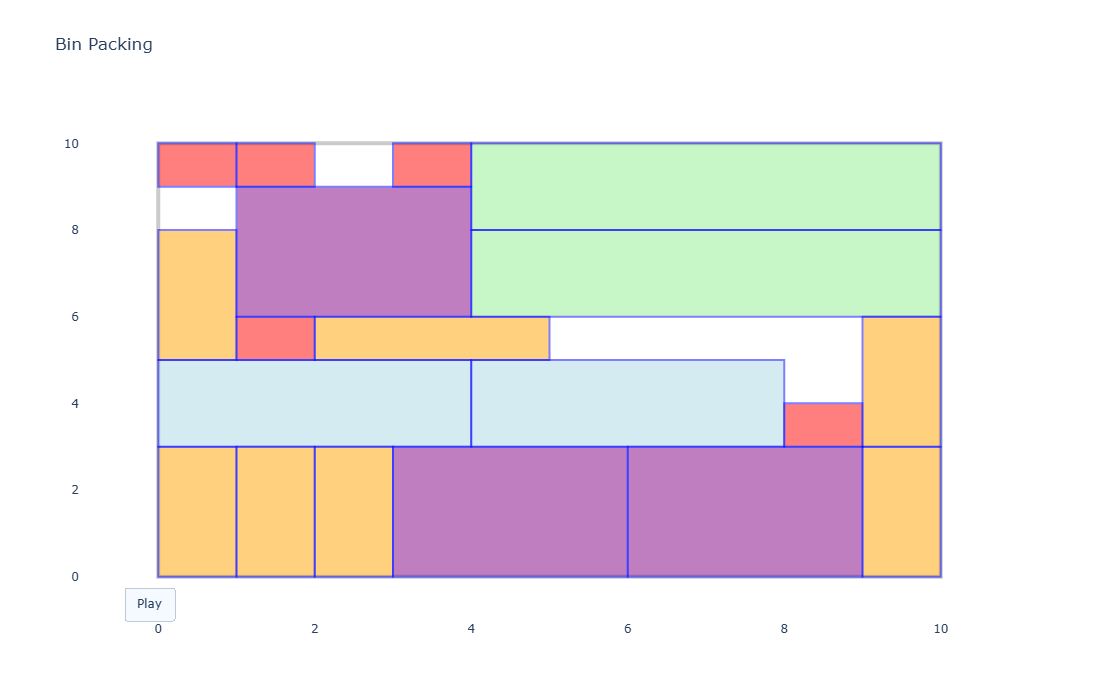

GIF guardado como: 2DBPP_v2.gif


In [30]:
import pandas as pd
import plotly.graph_objects as go
from PIL import Image
import os

colores = {
    'A':'orange',
    'B':'lightgreen', 
    'C':'purple', 
    'D':'lightblue',
    'E':'red'
}
# Crear la figura
fig = go.Figure()

# Agregar el contenedor como un rectángulo grande
fig.add_shape(
    type="rect",
    x0=0, y0=0, x1=ancho_maximo, y1=largo_maximo,
    line=dict(color="black", width=4),
    fillcolor="white",
    opacity=0.2
)

# Configurar la animación
fig.update_layout(
    title="Bin Packing",
    showlegend=False,
    width=700,
    height=700,
    xaxis=dict(range=[-1,ancho_maximo+1]),
    yaxis=dict(range=[-1,largo_maximo+1]),
    plot_bgcolor="white",
    updatemenus=[dict(
        type="buttons",
        x=0.1,
        xanchor="right",
        y=0,
        yanchor="bottom",
        buttons=[dict(
            label="Play",
            method="animate",
            args=[None, dict(frame=dict(duration=1000, redraw=True), fromcurrent=True)]
        )]
    )]
)

# Crear el directorio para guardar los frames
output_dir = "frames"
os.makedirs(output_dir, exist_ok=True)

# Crear la animación
frames = []
for i in range(len(output)):
    tipo_articulo = output['articulo'][i]
    # Agregar un rectángulo por cada frame
    fig.add_shape(
        type="rect",
        x0=output['x'][i], y0=output['y'][i],
        x1=output['x'][i] + output['ancho_aux'][i], y1=output['y'][i] + output['largo_aux'][i],
        line=dict(color="blue", width=2),
        fillcolor=colores[tipo_articulo[0]],  # Asignar color a cada vehículo,
        opacity=0.5,
        #label = tipo_articulo,

    )
    
    # Guardar cada frame como imagen
    fig.write_image(f"{output_dir}/frame_{i}.png")
    
    # Crear un frame para la animación
    frames.append(go.Frame(
        data=[go.Scatter(x=[0], y=[0], mode="markers")],
        name=f"Frame_{i}"
    ))

# Asignar los frames a la figura para la animación
    fig.frames = frames

# Mostrar la figura
fig.show()

# Convertir las imágenes a un GIF usando Pillow
frames = []
for i in range(len(output)):
    frame_path = f"{output_dir}/frame_{i}.png"
    img = Image.open(frame_path)
    frames.append(img)

# Guardar el GIF
gif_output_path = "2DBPP_v2.gif"
frames[0].save(gif_output_path, save_all=True, append_images=frames[1:], duration=1000, loop=0)

# Limpiar los archivos temporales (imágenes de los frames)
for i in range(len(output)):
    os.remove(f"{output_dir}/frame_{i}.png")

print(f"GIF guardado como: {gif_output_path}")
